Pricing European Options using COS method proposed by Fang and Oosterlee in 2008 under GBM.

I propose this method as a flexible method for pricing options where the underlying process can be easily changed at no additional cost, additionally it should in theory be less computationally expensive than a MC simulation method. I test the COS method, Monte-Carlo Simulation Method and Black-Scholes Method in evaluating the option price for a vanilla European option where the underlying follows the process:

We assumme the log stock price $$S_t$$ follows the dynamic under a Geometric Brownian Motion
$$
dS_t = \mu S_t dt + \sigma S_t dW_t
$$
where $$W_t$$ is a Weiner process.


The advantages purported of the COS method over its MC counterparts are:

Speed and Efficiency:
A low number of Cosine terms are needed to gain an accurate price comapred to simulating (typically millions) of paths for an accurate MC estimate resulting in better convergence speed and being less computationally demanding. 

Stochastic:
COS works well for processes with a known characteristic function e.g. Heston and VG as they are easy to compute and implement resulting is us only needed a few cosine terms making the task computionally less intense. 
COS is deterministic given we have the charactersitic function whereas MC is inherently stochastic needing random variables. 

Monte Carlo simulations have slow convergence rates. The error decreases at a rate proportional to the sq. root of M meaning to halve the error, you need to quadruple the number of simulations, which can be computationally expensive.

However, COS is ideal for handling European options and cannot handle path based options as easily as MC methods which are inherently path based

In this script I will evaluate some of the advantages of the COS method.



In [15]:
#import libraries
import numpy as np
from scipy.stats import norm
from scipy.special import erf
import matplotlib.pylab as plt
from IPython import display
import time
from scipy.stats import norm


In [16]:
# Option Parameters
S0 = 100 # spot price
r = 0.1 #rfr
q = 0.0 #dividend yield
dt = 0.1 # time step
sigma = 0.25 #Realized volatility
K = np.arange(50,151,10)#strike price to evaluate across spectrum of deep ITM, ATM, OTM options

#Working under a risk-netural measure so I will adjust mu so it is a martingale under the risk-neutral measure
mu = (r-q) - 0.5*sigma**2

#We are using the Log-Price 
#The log stock price is normally distributed so the cumulants coincide with the moments 
cum1 = (mu - 0.5*sigma**2)*dt #first cumulant
cum2 = sigma**2 * dt#second cumulant
cum4 = 0 #fourth cumulant

L = 10 #Constant as set in the paper
a = cum1 - L * (np.sqrt(cum2 + np.sqrt(cum4))) #a,b are the truncated intervals in evaluating the options value
b = cum1 + L * (np.sqrt(cum2 + np.sqrt(cum4)))
N = 32 #Suitable value for numerical approximation

In [17]:
def StdNormCdf(z):
    phi = 0.5 * (1 + erf(z/np.sqrt(2)))
    return phi

# Black Scholes Model 
def BlackScholes(S, K, r, q, dt, sigma, type):
    S = S * np.exp(-q * dt)
    d1 = np.divide((np.log(np.divide(S, K)) + (r + 1/2 * np.power(sigma, 2)) * dt), (sigma * np.sqrt(dt)))
    d2 = d1 - sigma * np.sqrt(dt)
    call  = np.multiply(S, StdNormCdf(d1)) - np.multiply(np.multiply(K, np.exp(-r * dt)), StdNormCdf(d2))
    put  = call + np.multiply(K, np.exp(-r * dt)) - S
    if type == 'call':
        return call
    elif type == 'put': 
        return put

BlackScholes(S0, K, r, q, dt, sigma, 'call')

array([5.04975083e+01, 4.05970100e+01, 3.06965139e+01, 2.07992263e+01,
       1.11352431e+01, 3.65996845e+00, 5.89616135e-01, 4.45778141e-02,
       1.70912451e-03, 3.71316085e-05, 5.08421755e-07])

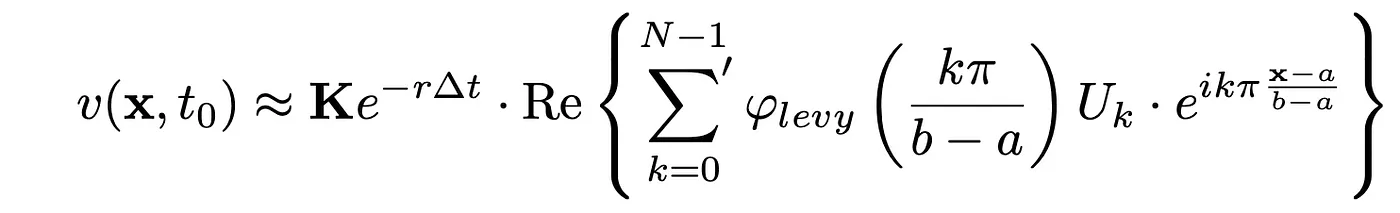

In [67]:
#The formula for the option value is given by the following equation
display.Image("/Users/umar/Downloads/COS 1.png")            

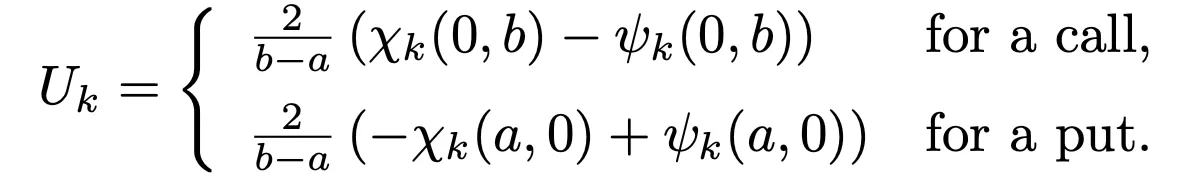

In [68]:
#Where U_k is a cosine series expansion define by the following equation
display.Image("/Users/umar/Downloads/COS 2.png")

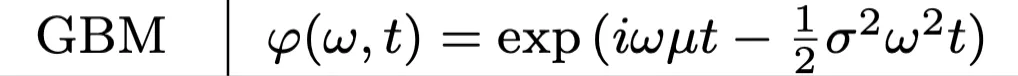

In [69]:
#The phi of the levy process is defined by the characterisitc function of the underlying process, in this case GBM defined as 
display.Image("/Users/umar/Downloads/COS 3.png")

Now to coding the COS method

In [18]:
#Def chi as taken from equation 22 in the reference paper
def CHI(k, a, b, c, d):
    bma = b-a
    uu = k * np.pi/bma
    chi = np.multiply(np.divide(1, (1 + np.power(uu,2))), (np.cos(uu * (d-a)) * np.exp(d) - np.cos(uu * (c-a)) * np.exp(c) + np.multiply(uu,np.sin(uu * (d-a))) * np.exp(d)-np.multiply(uu,np.sin(uu * (c-a))) * np.exp(c)))
    return chi

In [19]:
#Def psi as taken from equation 23 in the reference paper
def PSI(k, a, b, c, d):
    bma= b-a
    uu = k * np.pi/bma
    uu[0] = 1
    psi = np.divide(1,uu) * ( np.sin(uu * (d-a)) - np.sin(uu * (c-a)) )
    psi[0]= d-c
    return psi

In [20]:
#Def U_k as taken from equation 29 in the reference paper
def UK(k,a,b,type):
    bma = b-a
    if type == 'put': 
        UK  = 2 / bma * (-CHI(k,a,b,a,0) + PSI(k,a,b,a,0) )
    elif type == 'call':
        UK = 2 / bma * (CHI(k,a,b,0,b) - PSI(k,a,b,0,b))
    return UK 

In [21]:
#characteristic function of GBM
def charfuncGBM(s,r,q,sigma,T):
    cf = np.exp(((r-q) - 0.5 * np.power(sigma,2)) * 1j * np.multiply(T,s) - 0.5 * np.power(sigma,2) * T * np.power(s,2))
    return cf

Finally calculate the option value using the COS method according to equation 30 in the reference paper

In [22]:
def OptionValueCOSGBM(S0,K,r,q,dt,sigma,N,a,b,type): 
    bma = b-a
    k  = np.arange(N+1) #
    u  = k * np.pi/(b-a)
    V_COS = np.zeros((np.size(K))) #initialize the array to store the option values
    CFBS = charfuncGBM(u,r,q,sigma,dt) #Characteristic function of the GBM
    for m in range(0,np.size(K)): #Loop over the strike prices
        x  = np.log(S0/K[m]) #log(stock price/strike price)
        Term = np.exp(1j * k * np.pi * (x-a)/bma)
        Fk = np.real(np.multiply(CFBS, Term))
        Fk[0]=0.5 * Fk[0] 
        V_COS[m] = K[m] * np.sum(np.multiply(Fk,UK(k,a,b,type))) * np.exp(-r*dt)
    return V_COS

"""
Parameters:
    - S0: Init stock price.
    - K: Strike prices.
    - r: Rfr.
    - q: Dividend yield .
    - dt: Time to maturity .
    - sigma: Volatility of the underlying 
    - N: Number of terms in the COS series expansion.
    - a: Lower bound of the truncation domain for COS method.
    - b: Upper bound of the truncation domain for COS method.
    - option_type: Type of the option (call or put).
    Returns V_COS: Option values computed using the COS method for each strike price in K.
    """

'\nParameters:\n    - S0: Init stock price.\n    - K: Strike prices.\n    - r: Rfr.\n    - q: Dividend yield .\n    - dt: Time to maturity .\n    - sigma: Volatility of the underlying \n    - N: Number of terms in the COS series expansion.\n    - a: Lower bound of the truncation domain for COS method.\n    - b: Upper bound of the truncation domain for COS method.\n    - option_type: Type of the option (call or put).\n    Returns V_COS: Option values computed using the COS method for each strike price in K.\n    '

Evaluate the option value obtained using the COS method and benchmark against the value using the Black Scholes model

In [23]:
print('The values of the option with strike ',K, 'are', OptionValueCOSGBM(S0,K,r,q,dt,sigma,N,a,b,'call'))
print('The Reference Values of BS are: ', BlackScholes(S0, K, r, q, dt, sigma, 'call'), 
print('The abs errors are: ', abs(OptionValueCOSGBM(S0,K,r,q,dt,sigma,N,a,b,'call') - BlackScholes(S0, K, r, q, dt, sigma, 'call'))))

The values of the option with strike  [ 50  60  70  80  90 100 110 120 130 140 150] are [4.95102781e+01 4.05957890e+01 3.06965139e+01 2.07992262e+01
 1.11352431e+01 3.65996849e+00 5.89616166e-01 4.45777833e-02
 1.70902205e-03 3.70995854e-05 6.13606823e-07]
The abs errors are:  [9.87230196e-01 1.22095559e-03 1.20761783e-08 1.01094667e-07
 3.47272895e-08 3.37980075e-08 3.10350523e-08 3.07631586e-08
 1.02455447e-07 3.20231164e-08 1.05185069e-07]
The Reference Values of BS are:  [5.04975083e+01 4.05970100e+01 3.06965139e+01 2.07992263e+01
 1.11352431e+01 3.65996845e+00 5.89616135e-01 4.45778141e-02
 1.70912451e-03 3.71316085e-05 5.08421755e-07] None


The values are very close at N=32 which seems to be big enough to obtain accurate results for our options. Lets analyse how the COS method converges towards the BS provided value over N.

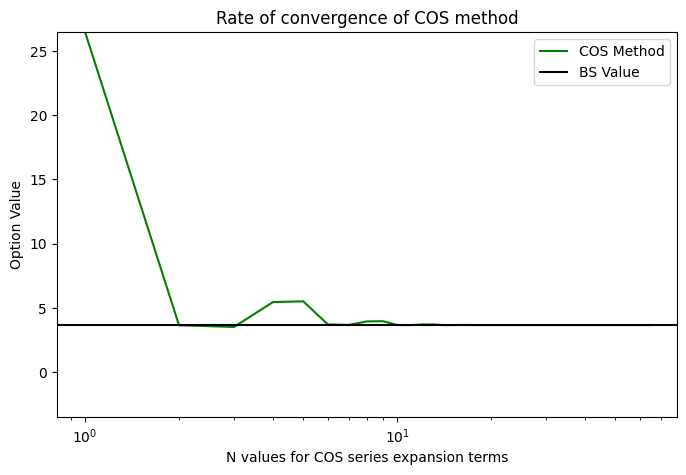

In [131]:
# Option Parameters
S0 = 100 
r = 0.1 
q = 0.0 
dt = 0.1 
sigma = 0.25 
K = 100 #Fixed strike price
cum1 = (mu - 0.5*sigma**2)*dt 
cum2 = sigma**2 * dt
cum4 = 0 
L = 10
a = cum1 - L * (np.sqrt(cum2 + np.sqrt(cum4))) 
b = cum1 + L * (np.sqrt(cum2 + np.sqrt(cum4)))

BS_value=BlackScholes(S0, K, r, q, dt, sigma, 'call')

N_values=np.arange(1,65,1)
cos_options_values=[]
    
def OptionValueCOSGBM(S0,K,r,q,dt,sigma,N,a,b,type): 
    bma = b-a
    k  = np.arange(N+1) 
    u  = k * np.pi/(b-a)
    CFBS = charfuncGBM(u,r,q,sigma,dt) 
    x  = np.log(S0/K) 
    Term = np.exp(1j * k * np.pi * (x-a)/bma)
    Fk = np.real(np.multiply(CFBS, Term))
    Fk[0]=0.5 * Fk[0] 
    V_COS = K * np.sum(np.multiply(Fk,UK(k,a,b,type))) * np.exp(-r*dt)
    return V_COS

for N in N_values:
    cos_value=OptionValueCOSGBM(S0,K,r,q,dt,sigma,N,a,b,'call')
    cos_options_values.append(cos_value)

plt.figure(figsize=(8,5))
plt.title('Rate of convergence of COS method')
plt.ylim(-min(cos_options_values), max(cos_options_values))
plt.plot(N_values,cos_options_values, label='COS Method', color='green')
plt.axhline(y=BS_value,label='BS Value',color='black',linestyle='-')
plt.xlabel('N values for COS series expansion terms') 
plt.ylabel('Option Value')
plt.xscale('log')
plt.legend()
plt.show()



We can see that even after just 10 terms in the COS expansion we see extremely high accuracy in the pricing of an option. 

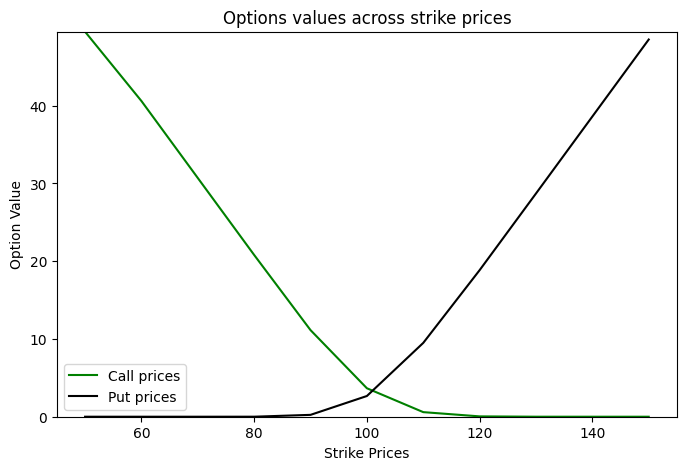

In [25]:
# Option Parameters
S0 = 100 
r = 0.1 
q = 0.0 
dt = 0.1 
sigma = 0.25 
K = np.arange(50, 151, 10) 
cum1 = (mu - 0.5*sigma**2)*dt 
cum2 = sigma**2 * dt
cum4 = 0 
L = 10
a = cum1 - L * (np.sqrt(cum2 + np.sqrt(cum4))) 
b = cum1 + L * (np.sqrt(cum2 + np.sqrt(cum4)))

BS_value = BlackScholes(S0, K, r, q, dt, sigma, 'call')

def OptionValueCOSGBM(S0,K,r,q,dt,sigma,N,a,b,type): 
    bma = b-a
    k  = np.arange(N+1) #
    u  = k * np.pi/(b-a)
    V_COS = np.zeros((np.size(K)))
    CFBS = charfuncGBM(u,r,q,sigma,dt) 
    for m in range(0,np.size(K)): 
        x  = np.log(S0/K[m]) 
        Term = np.exp(1j * k * np.pi * (x-a)/bma)
        Fk = np.real(np.multiply(CFBS, Term))
        Fk[0]=0.5 * Fk[0] 
        V_COS[m] = K[m] * np.sum(np.multiply(Fk,UK(k,a,b,type))) * np.exp(-r*dt)
    return V_COS

call_prices = OptionValueCOSGBM(S0, K, r, q, dt, sigma, N, a, b, "call")
put_prices = OptionValueCOSGBM(S0, K, r, q, dt, sigma, N, a, b, 'put')

plt.figure(figsize=(8, 5))
plt.title('Options values across strike prices')
plt.ylim(min(min(call_prices), min(put_prices)), max(max(call_prices), max(put_prices)))
plt.plot(K, call_prices, label='Call prices', color='green')
plt.plot(K, put_prices, label='Put prices', color='black', linestyle='-')
plt.xlabel('Strike Prices')
plt.ylabel('Option Value')
plt.legend()
plt.show()

The options evolves as we would expect it to.

Evaluate compute time as a measure of efficiency of methods

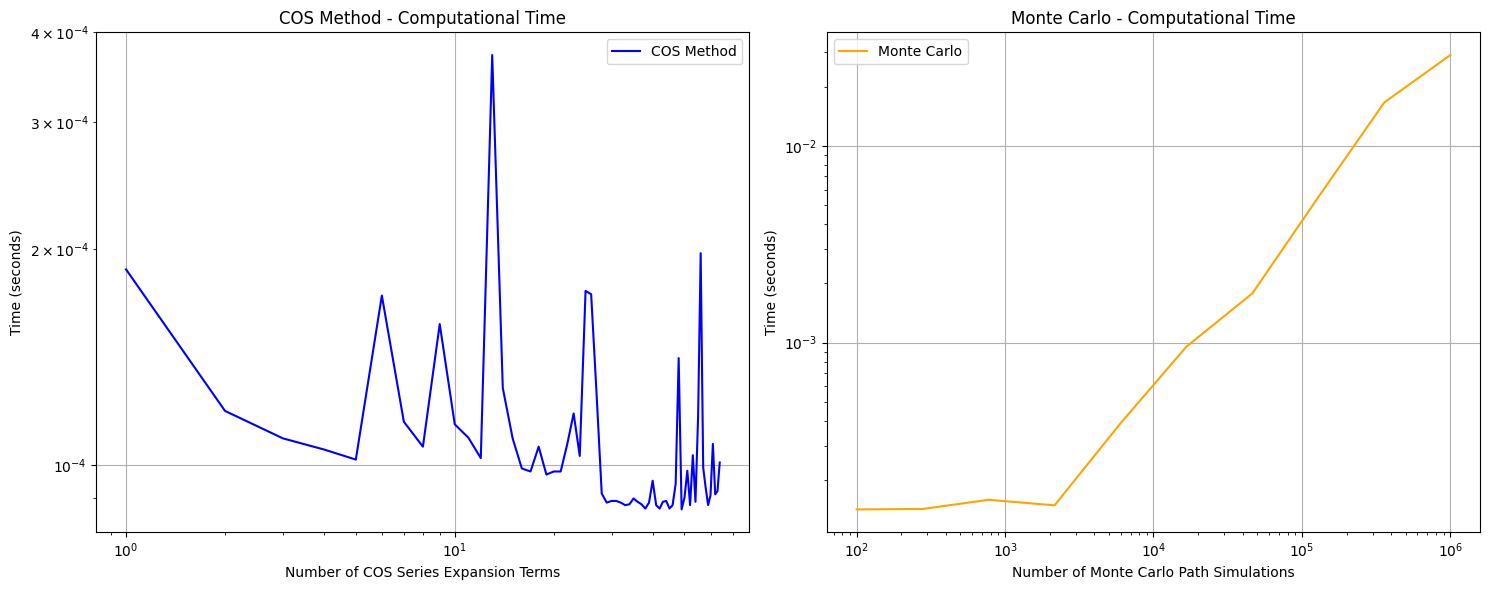

In [211]:
#Parameters
# Option Parameters
np.random.seed(456)    
S0 = 100 
r = 0.1 
q = 0.0 
dt = 0.1 
sigma = 0.25 
K = 100 #Fixed strike price
cum1 = (mu - 0.5*sigma**2)*dt 
cum2 = sigma**2 * dt
cum4 = 0 
L = 10
a = cum1 - L * (np.sqrt(cum2 + np.sqrt(cum4))) 
b = cum1 + L * (np.sqrt(cum2 + np.sqrt(cum4)))

def MonteCarlo(S0, K, r, q, dt, sigma, M, type): #< represents the number of path simulations which we will vary 
    np.random.seed(0)  # For reproducibility
    Z = np.random.randn(M)
    S_T = S0 * np.exp((r - q - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * Z)
    
    if type == 'call':
        payoff = np.maximum(S_T - K, 0)
    elif type == 'put':
        payoff = np.maximum(K - S_T, 0)
    return np.exp(-r * dt) * np.mean(payoff)

N_values = np.arange(1, 65, 1)  # Number of terms in COS method
M_values = np.logspace(2, 6, num=10, base=10, dtype=int)  # Number of Monte Carlo paths 

cos_times = []
mc_times = []
cos_values = []
mc_values = []

# Measure COS Method times and results

def OptionValueCOSGBM(S0,K,r,q,dt,sigma,N,a,b,type): 
    bma = b-a
    k  = np.arange(N+1) 
    u  = k * np.pi/(b-a)
    CFBS = charfuncGBM(u,r,q,sigma,dt) 
    x  = np.log(S0/K) 
    Term = np.exp(1j * k * np.pi * (x-a)/bma)
    Fk = np.real(np.multiply(CFBS, Term))
    Fk[0]=0.5 * Fk[0] 
    V_COS = K * np.sum(np.multiply(Fk,UK(k,a,b,type))) * np.exp(-r*dt)
    return V_COS

# Measure COS Method times and results
for N in N_values:
    start_time = time.time()  # Start the timer
    cos_value = OptionValueCOSGBM(S0, K, r, q, dt, sigma, N, a, b, 'call')
    cos_times.append(time.time() - start_time)  # Append the time taken
    cos_values.append(cos_value)  # Append the COS value

# Measure Monte Carlo Method times and results
for M in M_values:
    start_time = time.time()  # Start the timer
    mc_value = MonteCarlo(S0, K, r, q, dt, sigma, M, 'call')
    mc_times.append(time.time() - start_time)  # Append the time taken
    mc_values.append(mc_value)  # Append the Monte Carlo value

# Plot COS vs Monte Carlo computational time

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# COS Method Computational Time
ax1.plot(N_values, cos_times, label='COS Method', color='blue')
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_xlabel('Number of COS Series Expansion Terms')
ax1.set_ylabel('Time (seconds)')
ax1.set_title('COS Method - Computational Time')
ax1.legend()
ax1.grid(True)

#  Monte Carlo Computational Time
ax2.plot(M_values, mc_times, label='Monte Carlo', color='orange')
ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.set_xlabel('Number of Monte Carlo Path Simulations')
ax2.set_ylabel('Time (seconds)')
ax2.set_title('Monte Carlo - Computational Time')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

While we have a spike in the conputational time for the COS method it generally stays below the threshold quickly exceeded by the Monte-carlo method suggesting that in terms of increasing accuracy of the computation of the option value as shown in a graph below the COS method will be superior. This is particulary valuable to large corporations trading vast levels of options or setting option prices as they need to fulfill the contraints of being highly accurate and highly efficient due to the non-negligable cost of compute at this scale

Plot Monte Carlo Convergence

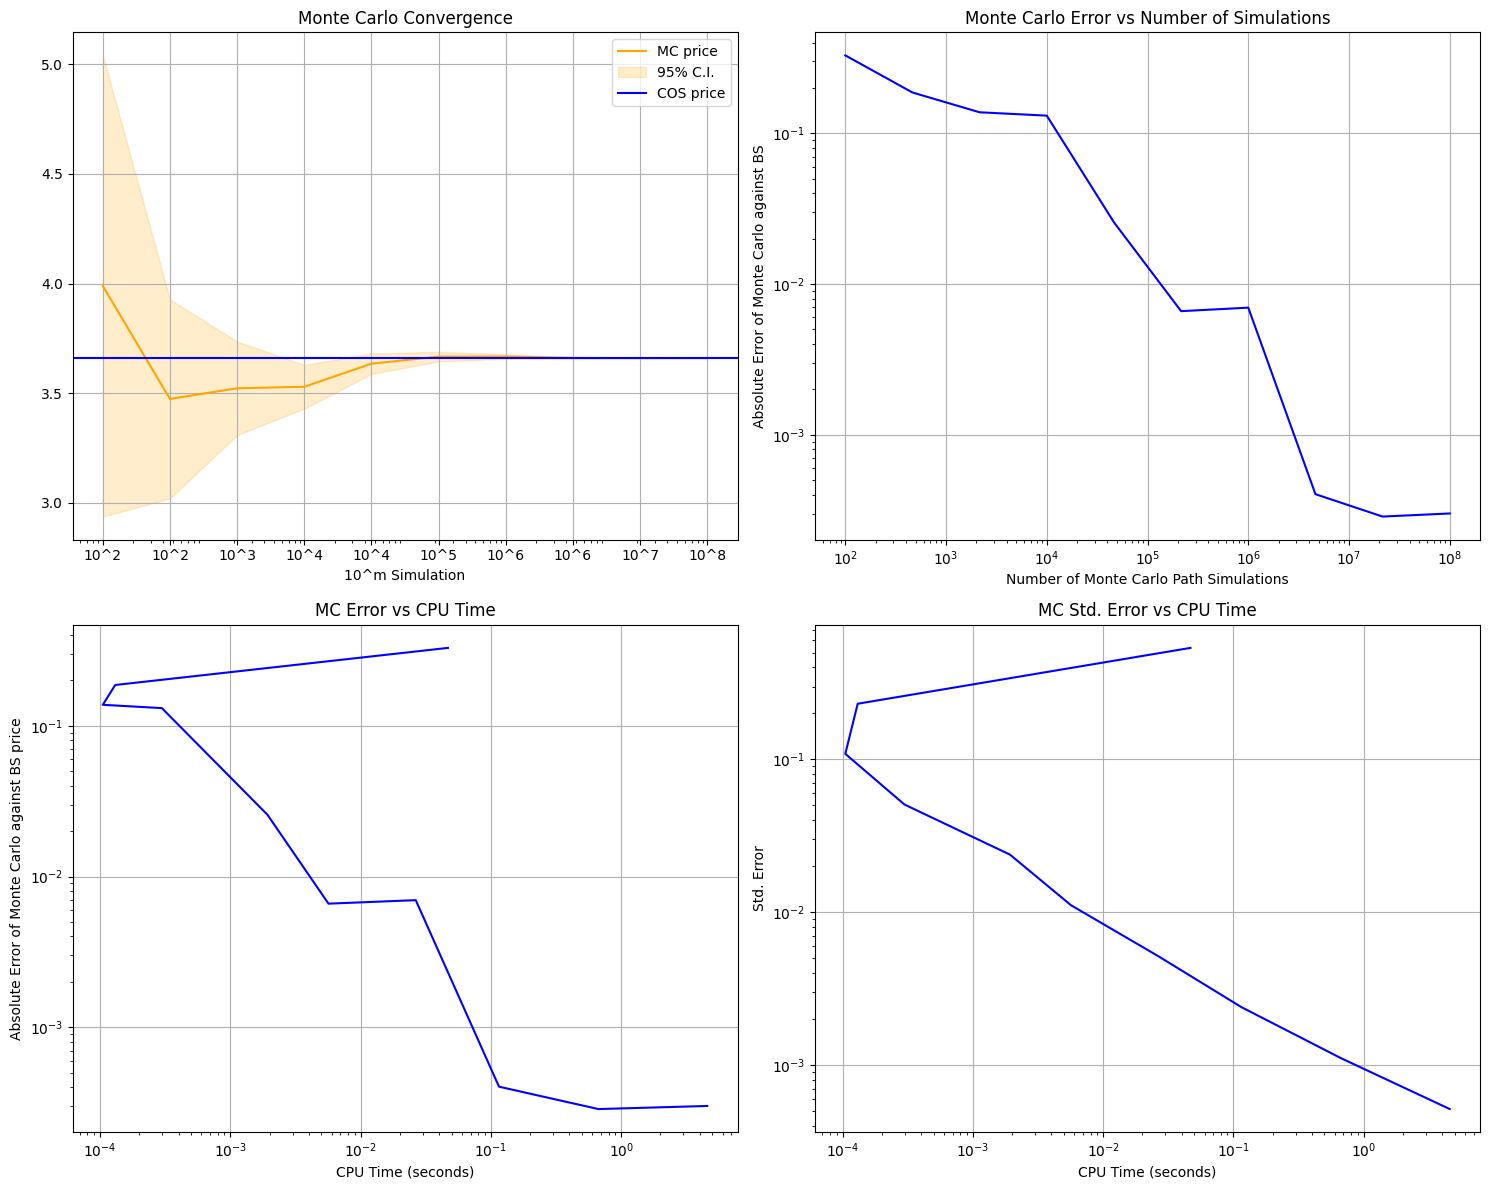

In [212]:
alpha = 0.05  # for 95% confidence interval
Z = norm.ppf(1 - alpha / 2)  # Z-score for 95% confidence interval (approximately 1.96)

def MonteCarloStdErr(S0, K, r, q, dt, sigma, M, option_type):
    np.random.seed(0)  # For reproducibility
    Z = np.random.randn(M) #< represents the number of path simulations which we will vary
    S_T = S0 * np.exp((r - q - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * Z)
    
    if option_type == 'call':
        payoff = np.maximum(S_T - K, 0)
    elif option_type == 'put':
        payoff = np.maximum(K - S_T, 0)
    
    discounted_payoff = np.exp(-r * dt) * payoff
    mean_payoff = np.mean(discounted_payoff)
    std_err = np.std(discounted_payoff) / np.sqrt(M)  # Standard error
    
    return mean_payoff, std_err, S_T

# Set up N values for COS, M values for Monte Carlo
N_values = np.arange(1, 65, 1)  # Varying number of terms in COS method
M_values = np.logspace(2, 8, num=10, base=10, dtype=int)  # Varying number of Monte Carlo paths

# Store results
cos_values = []
mc_values = []
mc_stderr = []
mc_paths= []
mc_times = []

# Compute COS prices
for N in N_values:
    cos_value = OptionValueCOSGBM(S0, K, r, q, dt, sigma, N, a, b, 'call')
    cos_values.append(cos_value)

for M in M_values:
    start_time = time.time()  # record CPU times
    mc_value, stderr, paths = MonteCarloStdErr(S0, K, r, q, dt, sigma, M, 'call')
    mc_times.append(time.time() - start_time)  
    mc_values.append(mc_value)
    mc_stderr.append(stderr)
    mc_paths.append(paths)

# Convert to numpy arrays for easier plotting
cos_values = np.array(cos_values)
mc_values = np.array(mc_values)
mc_stderr = np.array(mc_stderr)
mc_times = np.array(mc_times)

# Calculate confidence intervals for Monte Carlo
mc_upper_bound = mc_values + Z * mc_stderr
mc_lower_bound = mc_values - Z * mc_stderr

abs_mc_error=abs(mc_values - BlackScholes(S0, K, r, q, dt, sigma, 'call'))

# Create plots

# Plot the results side by side
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

# Monte Carlo Convergence
ax1.plot(M_values, mc_values, label='MC price', color='orange', linewidth=1.5)
ax1.fill_between(M_values, mc_lower_bound, mc_upper_bound, color='orange', alpha=0.2, label='95% C.I.')
ax1.axhline(y=cos_values[-1], color='blue', linestyle='-', label='COS price', linewidth=1.5)  # COS price
ax1.set_xscale('log')
ax1.set_xlabel('10^m Simulation')
ax1.set_xticks(M_values)
ax1.set_xticklabels([f'10^{int(np.log10(m))}' for m in M_values])
ax1.set_title('Monte Carlo Convergence')
ax1.legend()
ax1.grid(True)

# Monte Carlo Convergence Error vs Number of Simulations
ax2.plot(M_values, abs_mc_error, label='Monte Carlo Convergence Error', color='blue', linewidth=1.5)
ax2.set_yscale('log')
ax2.set_xscale('log')
ax2.set_xlabel('Number of Monte Carlo Path Simulations')
ax2.set_ylabel('Absolute Error of Monte Carlo against BS')
ax2.set_title('Monte Carlo Error vs Number of Simulations')
ax2.grid(True)

# Monte Carlo Convergence Error vs CPU Time
ax3.plot(mc_times, abs_mc_error, label='Monte Carlo Convergence Error', color='blue', linewidth=1.5)
ax3.set_yscale('log')
ax3.set_xscale('log')
ax3.set_xlabel('CPU Time (seconds)')
ax3.set_ylabel('Absolute Error of Monte Carlo against BS price')
ax3.set_title('MC Error vs CPU Time')
ax3.grid(True)

#  Monte Carlo Std. Error vs CPU Time
ax4.plot(mc_times, mc_stderr, label='Monte Carlo Std. Error', color='blue', linewidth=1.5)
ax4.set_yscale('log')
ax4.set_xscale('log')
ax4.set_xlabel('CPU Time (seconds)')
ax4.set_ylabel('Std. Error')
ax4.set_title('MC Std. Error vs CPU Time')
ax4.grid(True)

plt.tight_layout()
plt.show()


As expected, the Monte Carlo standard error decreases as CPU time increases. This inverse relationship highlights that running more simulations leads to more accurate estimations, though at a greater computational cost. The initial fluctuations observed in CPU time could be attributed to random variations in system performance, possibly caused by background processes on a personal computer or other external factors.

To mitigate this, a potential improvement would be to take the average CPU time over several runs (e.g., num_sim = 3). This would smooth out any inconsistencies in individual simulation times and provide a more accurate representation of the average computational load e.g.:


for i in range(num_sim):
    avg_time += time.time() - start_time
avg_time /= num_sim


The relationship between the error and CPU time can be seen to be nearly linear, this suggests that increases in precision will require a proportional increase in CPU time. By extrapolating from this linear trend, we can estimate the additional CPU cost required to achieve higher levels of precision, which is useful for optimizing and balancing computational resources during Monte Carlo simulations i.e. define our desired level of precision and maintain high confidence in our cost estimate.

Now we will compute comparisons in times between MC and COD to see which is more efficient. 

/var/folders/pz/ppj3c3y97wb28xcmb96ybk6r0000gp/T/ipykernel_60977/3479481467.py:8: RuntimeWarning: divide by zero encountered in divide
  d1 = np.divide((np.log(np.divide(S, K)) + (r + 1/2 * np.power(sigma, 2)) * dt), (sigma * np.sqrt(dt)))
/var/folders/pz/ppj3c3y97wb28xcmb96ybk6r0000gp/T/ipykernel_60977/3479481467.py:8: RuntimeWarning: invalid value encountered in divide
  d1 = np.divide((np.log(np.divide(S, K)) + (r + 1/2 * np.power(sigma, 2)) * dt), (sigma * np.sqrt(dt)))


Average COS compute time: 0.00046 seconds
Average Monte Carlo compute time: 0.00749 seconds
Time difference (Monte Carlo - COS): 0.00703 seconds
Time ratio (Monte Carlo / COS): 16.35
Maximum execution time difference 0.04450 seconds


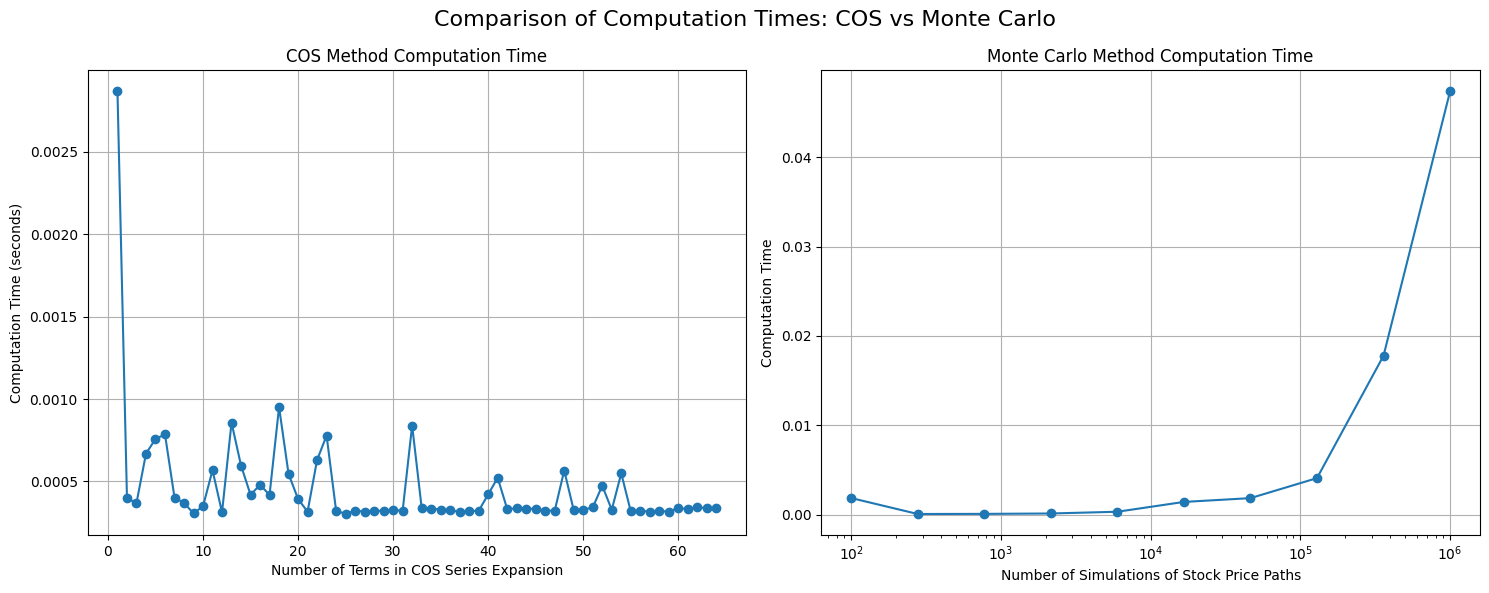

In [214]:
#Parameters
# Option Parameters
np.random.seed(456)
S0 = 100 
r = 0.1 
q = 0.0 
dt = 0.1 
sigma = 0.25 
N=15
K = np.arange(50, 151, 10)
mu = (r-q) - 0.5*sigma**2
L = 32 
cum1 = (mu - 0.5*sigma**2)*dt 
cum2 = sigma**2 * dt
cum4 = 0 
a = cum1 - L * (np.sqrt(cum2 + np.sqrt(cum4))) 
b = cum1 + L * (np.sqrt(cum2 + np.sqrt(cum4)))

cos_times = []
mc_times = []
cos_values = []
mc_values = []
cos_errors = []
mc_errors = []

N_values = np.arange(1, 65, 1)  
M_values = np.logspace(2, 6, num=10, base=10, dtype=int)

true_prices = BlackScholes(S0, K, dt, r, q, sigma, 'call')

def OptionValueCOSGBM(S0, K, r, q, dt, sigma, N, a, b, option_type): 
    bma = b - a
    k = np.arange(N + 1)
    u = k * np.pi / bma
    V_COS = np.zeros((np.size(K)))  #initialise array
    CFBS = charfuncGBM(u, r, q, sigma, dt)  
    
    for m in range(np.size(K)): 
        x = np.log(S0 / K[m]) 
        Term = np.exp(1j * k * np.pi * (x - a) / bma)
        Fk = np.real(np.multiply(CFBS, Term))
        Fk[0] *= 0.5  
        V_COS[m] = K[m] * np.sum(np.multiply(Fk, UK(k, a, b, option_type))) * np.exp(-r * dt)
    
    return V_COS

# Monte Carlo method function
def MonteCarlo(S0, K, r, q, dt, sigma, M, option_type): 
    Z = np.random.randn(M)
    S_T = S0 * np.exp((r - q - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * Z)
    
    mc_prices = []

    for strike in K:
        if option_type == 'call':
            payoff = np.maximum(S_T - strike, 0)
        elif option_type == 'put':
            payoff = np.maximum(strike - S_T, 0)
        
        price = np.exp(-r * dt) * np.mean(payoff)  # Take mean of payoffs
        mc_prices.append(price)  
    
    return mc_prices  

# Compute COS method prices and times
for N in N_values:
    start_time = time.time()
    cos_prices = OptionValueCOSGBM(S0, K, r, q, dt, sigma, N, a, b, 'call')
    cos_times.append(time.time() - start_time)
    cos_error = np.sqrt(np.mean((cos_prices - true_prices)**2))  # RMSE for each COS calculation
    cos_errors.append(cos_error)

# Compute Monte Carlo method prices and times
for M in M_values:
    start_time = time.time()
    mc_prices = MonteCarlo(S0, K, r, q, dt, sigma, M, 'call')
    mc_times.append(time.time() - start_time)
    mc_error = np.sqrt(np.mean((mc_prices - true_prices)**2))  # RMSE for each Monte Carlo calculation
    mc_errors.append(mc_error)

# Calculate the average computation times
avg_cos_time = np.mean(cos_times)
avg_mc_time = np.mean(mc_times)
max_cos_time = np.max(cos_times)
max_mc_time = np.max(mc_times)
time_difference = avg_mc_time - avg_cos_time
abs_time_difference = max_mc_time - max_cos_time
time_ratio = avg_mc_time / avg_cos_time

# Print results
print(f'Average COS compute time: {avg_cos_time:.5f} seconds')
print(f'Average Monte Carlo compute time: {avg_mc_time:.5f} seconds')
print(f'Time difference (Monte Carlo - COS): {time_difference:.5f} seconds')
print(f'Time ratio (Monte Carlo / COS): {time_ratio:.2f}')
print(f'Maximum execution time difference {abs_time_difference:.5f} seconds')

# Plot the results side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

ax1.plot(N_values, cos_times, marker='o')
ax1.set_title('COS Method Computation Time')
ax1.set_xlabel('Number of Terms in COS Series Expansion')
ax1.set_ylabel('Computation Time (seconds)')
ax1.grid(True)

ax2.plot(M_values, mc_times, marker='o')
ax2.set_title('Monte Carlo Method Computation Time')
ax2.set_xlabel('Number of Simulations of Stock Price Paths')
ax2.set_ylabel('Computation Time')
ax2.set_xscale('log')  # Use log scale for x-axis due to large range of M values
ax2.grid(True)

fig.suptitle('Comparison of Computation Times: COS vs Monte Carlo', fontsize=16)
plt.tight_layout()
plt.show()

The COS method demonstrates significantly higher computational efficiency compared to the Monte Carlo (MC) simulation, showing more than a 10x improvement in performance. As illustrated in the graphs, the complexity of compute time increases differently for both methods. For COS, computational time remains relatively stable, even as the number of expansion terms grows. In contrast, MC simulations exhibit exponential growth in compute time as the number of stock price paths increases.

As we approach the convergence regions—where both methods tend towards the Black-Scholes price—the COS method continues to outperform, providing accurate results in less time. Despite increasing the number of expansion terms, the COS method's time complexity remains manageable. This highlights COS as an optimal choice for tasks requiring high accuracy and quick execution, particularly in comparison to the significantly longer execution times required for the MC method as accuracy increases. This is extremely useful when dealing with multiple models that have defined characteristic functions such as the GBM.

Additionally, the COS method benefits from a more efficient vectorized implementation, which further reduces computational overhead and contributes to its faster execution time as can be seen below.



In [209]:
def OptionValueCOSGBM_vectorised(S0, K, r, q, dt, sigma, N, a, b, option_type):
    bma = b - a
    k = np.arange(N + 1)
    u = k * np.pi / bma
    
    CFBS = charfuncGBM(u, r, q, sigma, dt)
    
    # Compute x for all strike prices at once
    x = np.log(S0 / K)[:, np.newaxis]  
    
    # Compute Term for all strike prices and k values at once
    Term = np.exp(1j * k * np.pi * (x - a) / bma)
    
    Fk = np.real(CFBS * Term)
    
    Fk[:, 0] *= 0.5
    
    UK_values = UK(k, a, b, option_type)
    V_COS = K * np.sum(Fk * UK_values, axis=1) * np.exp(-r * dt)
    
    return V_COS

OptionValueCOSGBM_vectorised(S0, K, r, q, dt, sigma, N, a, b, 'call')

cos_times = []
cos_values = []

for N in N_values:
    start_time = time.time()  
    cos_value = np.mean(OptionValueCOSGBM_vectorised(S0, K, r, q, dt, sigma, N, a, b, 'call'))
    cos_times.append(time.time() - start_time)  
    cos_values.append(cos_value)  

avg_cos_time_vec = np.mean(cos_times)
time_ratio = avg_mc_time / avg_cos_time_vec
print(f'Average COS compute time for vectorised function: {avg_cos_time:.5f} seconds')
print(f'Time ratio (Monte Carlo / COS vectorised): {time_ratio:.2f}')

Average COS compute time for vectorised function: 0.00044 seconds
Time ratio (Monte Carlo / COS vectorised): 31.93


A marked improvement

Now will attempt to use the formulas derived by Fang(2008) to obtain the risk neutral density which will give us the distribution of option prices as determined under the risk neutral measure. The formulas are as given below:

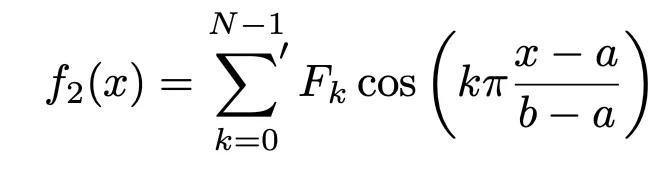

In [215]:
display.Image("/Users/umar/Downloads/COS 4.png")  

Where $F_k$'s =

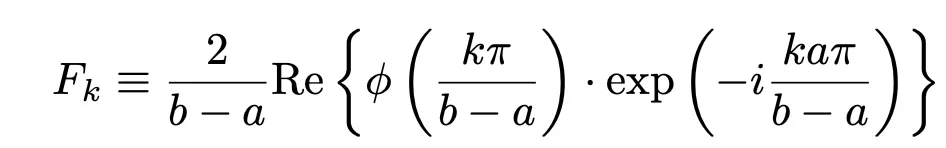

In [216]:
display.Image("/Users/umar/Downloads/COS 5.png")  

In [228]:
#Define our F_K function
def FK(k,a,b,r,q,sigma,T): 
    bma = b-a 
    FK = 2/bma * np.real(charfuncGBM(k*np.pi/bma,r,q,sigma,T) * np.exp(-(1j * k * a * np.pi) / bma ))
    return FK

#Extract our densities 
def RND(S0,K,a,b,r,q,sigma,T,N): 
    bma=b-a
    x=np.log(S0/K)
    cumsum= 0.5 * FK(0,a,b,r,q,sigma,T) * np.cos(0)
    for k in range(1,N):
        cumsum+=np.cos(k*np.pi*(x-1)/bma)*FK(k,a,b,r,q,sigma,T)
    return cumsum

 Now lets plot the risk-neutral density

[]

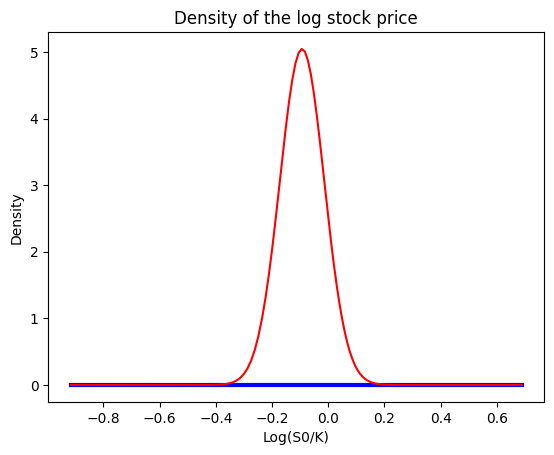

In [234]:
dt=0.1
mu=(r-1)-0.5*sigma**2
S0=np.arange(40,200,1)
k=100
N=256
Density=np.zeros(np.size(S0))
target=np.zeros(np.size(S0)) #Used the close formed expression to evaluate our pdf generated by the COS method formulae
for i in range(0,len(S0)):
    Density[i]=RND(S0[i],k,a,b,r,q,sigma,dt,N)
    target[i]=norm.pdf(np.log(S0[i]/k), loc=mu*dt, scale=sigma*np.sqrt(dt)) #Location of the mean and scale of the distribution are modified according to the time step and are taken from the lognormal distribution

axis=np.log(S0/k)
plt.plot(axis,Density, color='blue', linewidth=3)
plt.plot(axis,target, color='red')
plt.xlabel('Log(S0/K)')
plt.ylabel('Density')
plt.title('Density of the log stock price')
plt.plot()


The function accurately models the distribution

Results and Visualization:
Numerical Density (Blue Curve): This curve shows the risk-neutral density as computed by the custom COS Density function.
Target/Theoretical Density (Red Curve): This represents the log-normal distribution using the established closed-form density function.

The purple line indicates an overlap between the two curves, implying that the numerical and theoretical densities align well. The comparison between the numerical density (blue curve) and the theoretical density (red curve) suggests that the model accurately captures the distribution of the log stock price, especially around the mean, where the density is highest meaning our model is working correctly.

However, the tails of the distribution show a divergence between the two curves at extreme values/outlier. This could indicate that:

The numerical method (blue) might have limitations at extreme values.
The model might require further terms for approximation. 

Scaling Effects: The scale=sigma*np.sqrt(dt) correctly reflects the volatility of the stock price distribution. 

Next Steps:

Error Measurement: 
Calculate MSE. 
Measure the time complexity or computation time of the Density function for larger datasets.
Loop the custom COS function along different strike prices and/or different time-steps in order to get a broader insight into its effectiveness across varied situations. 

Conclusion:
The function successfully models the risk-neutral density of the log stock price. While the numerical and theoretical densities are well-aligned further analysis is needed at the distribution's tails and across different situations to better reflect on the accuracy. 

The COS method appeard computational faster than MC and more flexible than BS across stochastic processes with close-formed characteristic functions.